# **Analisis Sentimen Ulasan Pengguna Aplikasi TIX ID di Google Play Store dengan Deep Learning**

### **Import Library**

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('punkt_tab')
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stop words) dalam berbagai bahasa.
nltk.download('wordnet')

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.preprocessing import LabelEncoder

!pip install keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, MaxPooling1D, Flatten, BatchNormalization, GRU, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import requests
import csv
from io import StringIO
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Loading Dataset**

In [74]:
# Membaca dataset
TIXid_Reviews = pd.read_csv('ulasan_TIXID.csv')

In [75]:
# Menampilkan 5 data teratas
TIXid_Reviews.head()

,comment,rating,thumbsUpCount,at
0,ok semoga sukses selalu..,5,0,2025-04-13 14:19:27
1,bagusss sekaliii,5,0,2025-04-13 13:29:29
2,Kenapa aku gak bisa beli tiket yg 1Get 1 ya,4,0,2025-04-13 11:28:39
3,"pas promo sering error, terkadang udah waktunya promo dan masih awal waktu, banyak kursi yg blm di booking tapi tidak muncul promonya",1,0,2025-04-13 11:22:14
4,"saya mau daftar kok ga bisa weyy.... edit: sudah bisa, mantap 👍👍",5,0,2025-04-13 08:44:14


In [76]:
# Menampilkan 5 data terakhir
TIXid_Reviews.tail()

,comment,rating,thumbsUpCount,at
9995,"Kok sy sdah undang Teman, Dan mreka sdah instal tpi Kok sy ngk dpat"" bonus ? Dan sy login tpi Kok nomor Anda sdah trdaftar ?",1,0,2018-09-13 05:22:26
9996,"Ini keren bgd sih app nya.. banyak promo.. Buat yg baru download, masukin kode ini ya 7Q809Z Dijamin dapet voucher 25ribu.. jadi kalo beli tiket seharga 40ribu, kalian cuma bayar 15 ribu.. 😊😊😊",5,0,2018-09-13 03:55:21
9997,"Keren abis nih app.. Nih pake kode undangan ini ""29W9WY"" supaya dapat vocer gratis 10 tiket beneran gua pakek ini teraktir temen2",5,0,2018-09-13 02:24:21
9998,"Buat aplikasi yg bener lah, sia sia instal aplikasi.. Buka aplikasi aja sampai 2 jam lebih baru terbuka. Registrasi aja susah bener, sudah dimasukkan nama dan no hp.. Tpi loading nya sampai 3 jam. Itu pun jawabannya "" maaf coba lah beberapa saat lagi "" kan macam sempak.. Buang waktu ujung nya gagal..",1,4,2018-09-12 11:23:11
9999,Aplikasi terkeren yang saya temuin. banyak sekali diskon sama promo yang aku temuin. makasih TIX ID,5,0,2018-09-12 07:20:25


In [77]:
# Menampilkan informasi dataset meliputi jumlah baris, kolom, dan tipe data
TIXid_Reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   comment        10000 non-null  object
 1   rating         10000 non-null  int64 
 2   thumbsUpCount  10000 non-null  int64 
 3   at             10000 non-null  object
dtypes: int64(2), object(2)
memory usage: 312.6+ KB


In [78]:
# Mengubah tipe data kolom 'at' menjadi datetime
TIXid_Reviews['at'] = pd.to_datetime(TIXid_Reviews['at'])

# Mengecek tipe data setelah diubah
print(TIXid_Reviews.dtypes)

comment                  object
rating                    int64
thumbsUpCount             int64
at               datetime64[ns]
dtype: object


In [79]:
# Menampilkan nilai yang kosong
TIXid_Reviews.isnull().sum()

,0
comment,0
rating,0
thumbsUpCount,0
at,0


In [80]:
# Menghapus data duplikat
TIXid_Reviews.drop_duplicates(subset ='comment', keep ='first', inplace=True)

In [81]:
TIXid_Reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9993 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   comment        9993 non-null   object        
 1   rating         9993 non-null   int64         
 2   thumbsUpCount  9993 non-null   int64         
 3   at             9993 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 390.4+ KB


### **Preprocessing Text**

In [82]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update("banget","dan","atau","tapi","akan","iya","yaa","gak","nya","na","yg","yang","sih","ku","di","ga","ya","gaa","loh","kah","woi","woii","woy","saya","sayaa","sy","aku","akuu","anda","untuk","kakak","kak","kakk","ka","kk","kaka","min","mimin","kok","y","z","ini","lah")
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

    return stemmed_text
def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

def remove_emoji(text):
    if text is not None and isinstance(text, str):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticon
                                   u"\U0001F300-\U0001F5FF"  # simbol & objek
                                   u"\U0001F680-\U0001F6FF"  # transportasi
                                   u"\U0001F1E0-\U0001F1FF"  # bendera (kode negara)
                                   u"\U0001F700-\U0001F77F"  # simbol tambahan
                                   u"\U0001F780-\U0001F7FF"  # simbol tambahan lainnya
                                   u"\U0001F800-\U0001F8FF"  # simbol lagi
                                   u"\U0001F900-\U0001F9FF"  # emotikon tambahan
                                   u"\U0001FA00-\U0001FA6F"  # objek
                                   u"\U0001FA70-\U0001FAFF"  # objek tambahan
                                   u"\U0001F004-\U0001F0CF"  # kartu
                                   u"\U00002700-\U000027BF"  # simbol dingbat
                                   u"\U000024C2-\U0001F251"  # simbol lainnya
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text

In [83]:
# Fungsi untuk mengunduh dan memproses stopwords
def download_stopwords(url):
    response = requests.get(url)
    response.raise_for_status()  # Akan menimbulkan exception jika permintaan gagal
    stopwords = response.text.splitlines()
    return set(stopword.lower() for stopword in stopwords)  # Mengembalikan sebagai set untuk akses cepat

# URL dari file stopwords
url_stopwords = 'https://raw.githubusercontent.com/SokKanaTorajd/indonesia-stopwords/refs/heads/main/indonesia-stopwords.txt'

# Unduh daftar stopwords
stopwords = download_stopwords(url_stopwords)

def filteringText(text):
    if text is not None and isinstance(text, str):
        words = text.split()  # Memecah teks menjadi token
        filtered_words = [word for word in words if word.lower() not in stopwords]  # Filter kata-kata
        return ' '.join(filtered_words)  # Gabungkan kembali menjadi teks
    else:
        return text  # Jika teks kosong atau tidak valid, kembalikan apa adanya

In [84]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "ferifikasi": "verifikasi", "apk": "aplikasi", "app": "aplikasi", "telephone": "telepon", "rubah": "ubah", "RS": "rumah sakit", "rs": "rumah sakit", "skt": "sakit", "bgini": "begini", "nik": "nomor induk kependudukan", "NIK": "nomor induk kependudukan", "kocak": "aneh", "cross check": "mengecek ulang", "sori": "maaf", "ges": "teman", "faskes": "fasilitas kesehatan", "gk": "tidak", "hp": "telepon", "smpe": "sampai", "mgkin": "mungkin", "sms": "short message service", "SMS": "short message service", "lemot": "lambat", "lemottt": "lambat", "lemott": "lambat", "busuk": "buruk", "no hp": "nomor telepon", "bobrokk": "rusak", "bobrok": "rusak", "udh": "sudah"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [85]:
# Menampilkan dataset yang belum dibersihkan
clean_df = TIXid_Reviews
clean_df

,comment,rating,thumbsUpCount,at
0,ok semoga sukses selalu..,5,0,2025-04-13 14:19:27
1,bagusss sekaliii,5,0,2025-04-13 13:29:29
2,Kenapa aku gak bisa beli tiket yg 1Get 1 ya,4,0,2025-04-13 11:28:39
3,"pas promo sering error, terkadang udah waktunya promo dan masih awal waktu, banyak kursi yg blm di booking tapi tidak muncul promonya",1,0,2025-04-13 11:22:14
4,"saya mau daftar kok ga bisa weyy.... edit: sudah bisa, mantap 👍👍",5,0,2025-04-13 08:44:14
...,...,...,...,...
9995,"Kok sy sdah undang Teman, Dan mreka sdah instal tpi Kok sy ngk dpat"" bonus ? Dan sy login tpi Kok nomor Anda sdah trdaftar ?",1,0,2018-09-13 05:22:26
9996,"Ini keren bgd sih app nya.. banyak promo.. Buat yg baru download, masukin kode ini ya 7Q809Z Dijamin dapet voucher 25ribu.. jadi kalo beli tiket seharga 40ribu, kalian cuma bayar 15 ribu.. 😊😊😊",5,0,2018-09-13 03:55:21
9997,"Keren abis nih app.. Nih pake kode undangan ini ""29W9WY"" supaya dapat vocer gratis 10 tiket beneran gua pakek ini teraktir temen2",5,0,2018-09-13 02:24:21
9998,"Buat aplikasi yg bener lah, sia sia instal aplikasi.. Buka aplikasi aja sampai 2 jam lebih baru terbuka. Registrasi aja susah bener, sudah dimasukkan nama dan no hp.. Tpi loading nya sampai 3 jam. Itu pun jawabannya "" maaf coba lah beberapa saat lagi "" kan macam sempak.. Buang waktu ujung nya gagal..",1,4,2018-09-12 11:23:11


In [86]:
# Membuat kolom 'text_no_emoji' untuk teks yang sudah dihapus emojinya
clean_df['text_no_emoji'] = clean_df['comment'].apply(remove_emoji)

# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['text_no_emoji'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Melakukan stemming dan menyimpan hasilnya di 'text_stemmed'
clean_df['text_stemmed'] = clean_df['text_stopword'].apply(toSentence).apply(stemmingText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stemmed']

In [87]:
# Menyimpan text hasil stemming terpisah
clean_df[['text_stemmed']].to_csv('hasil_text_stemmed.csv', index=False)

In [88]:
# Menampilkan dataset setelah preprocessing text
clean_df.head(2)

,comment,rating,thumbsUpCount,at,text_no_emoji,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemmed,text_akhir
0,ok semoga sukses selalu..,5,0,2025-04-13 14:19:27,ok semoga sukses selalu..,ok semoga sukses selalu,ok semoga sukses selalu,ok semoga sukses selalu,"[ok, semoga, sukses, selalu]","[ok, semoga, sukses, selalu]",ok moga sukses selalu,ok moga sukses selalu
1,bagusss sekaliii,5,0,2025-04-13 13:29:29,bagusss sekaliii,bagusss sekaliii,bagusss sekaliii,bagusss sekaliii,"[bagusss, sekaliii]","[bagusss, sekaliii]",bagusss sekaliii,bagusss sekaliii


### **Pelabelan**

In [89]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")


# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya ke dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [90]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    # untuk setiap kata dalam teks:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score >= 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
    else:
        polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [91]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
negative    6431
positive    3562
Name: count, dtype: int64


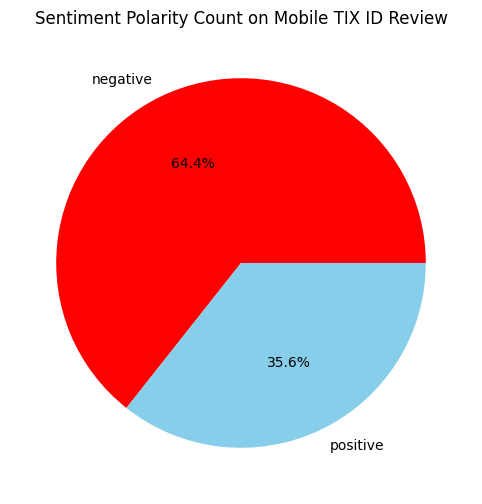

In [92]:
# Menghitung jumlah tiap polaritas
polarity_counts = clean_df['polarity'].value_counts()

# Plot diagram batang
plt.figure(figsize=(10, 6))
plt.pie(polarity_counts.values, labels=polarity_counts.index, autopct='%1.1f%%', colors=['red','skyblue'])
plt.title('Sentiment Polarity Count on Mobile TIX ID Review')
plt.show()

#### WordCloud Umum

In [93]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'positive_tweets' yang hanya berisi tweet dengan polaritas positif.
positive_tweets = clean_df[clean_df['polarity'] == 'positive']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'positive_tweets'.
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
positive_tweets = positive_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
positive_tweets.index += 1

In [94]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'negative_tweets' yang hanya berisi tweet dengan polaritas negatif.
negative_tweets = clean_df[clean_df['polarity'] == 'negative']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'negative_tweets'.
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'negative_tweets' berdasarkan 'polarity_score' secara menaik (ascending).
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)

# Memilih 10 baris pertama dari DataFrame yang sudah diurutkan.
negative_tweets = negative_tweets[0:10]

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
negative_tweets = negative_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
negative_tweets.index += 1

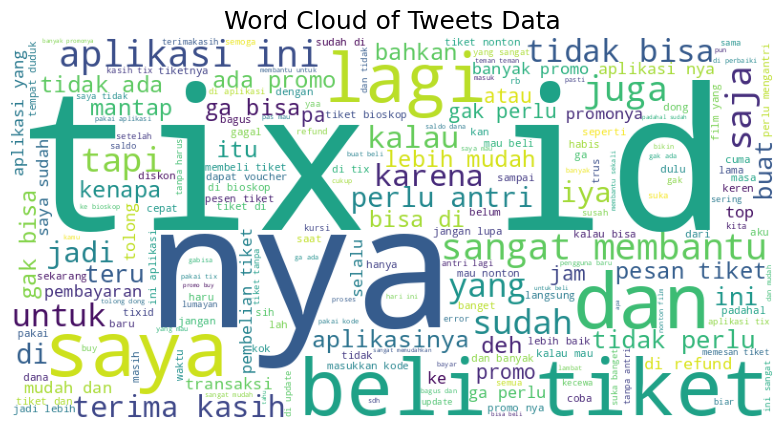

In [95]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'clean_df'.
for tweet in clean_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6)) # Membuat gambar dan sumbu untuk menampilkan word cloud
ax.set_title('Word Cloud of Tweets Data', fontsize=18) # Menetapkan judul untuk word cloud
ax.grid(False) # Menonaktifkan grid pada sumbu
ax.imshow((wordcloud)) # Menampilkan word cloud dalam gambar
fig.tight_layout(pad=0) # Mengatur layout gambar
ax.axis('off') # Menyembunyikan sumbu

# Menampilkan word cloud
plt.show()

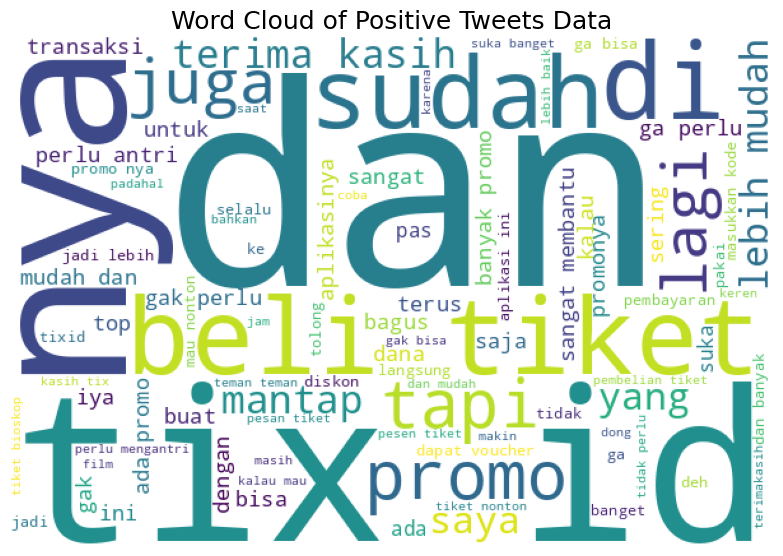

In [96]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam tweet positif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'positive_tweets'.
for tweet in positive_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

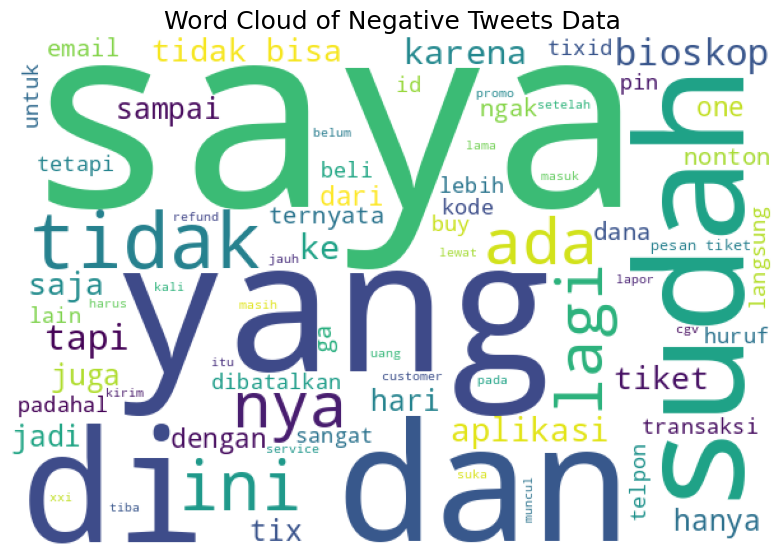

In [97]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam tweet negatif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'negative_tweets'.
for tweet in negative_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

### **Visualisasi Dataset**

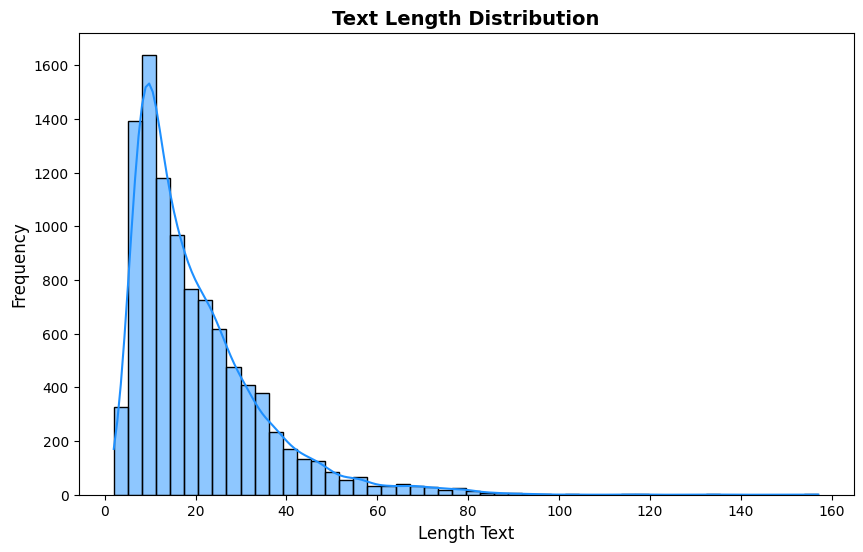

In [98]:
# Atur ukuran figure
plt.figure(figsize=(10, 6))

# Membuat distribusi panjang teks
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))

# Visualisasi distribusi panjang teks
sns.histplot(clean_df['text_length'], bins=50, kde=True, color='dodgerblue')

# Tambahkan judul dan label sumbu
plt.xlabel('Length Text', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Text Length Distribution', fontsize=14, fontweight='bold')

# Tampilkan plot
plt.show()

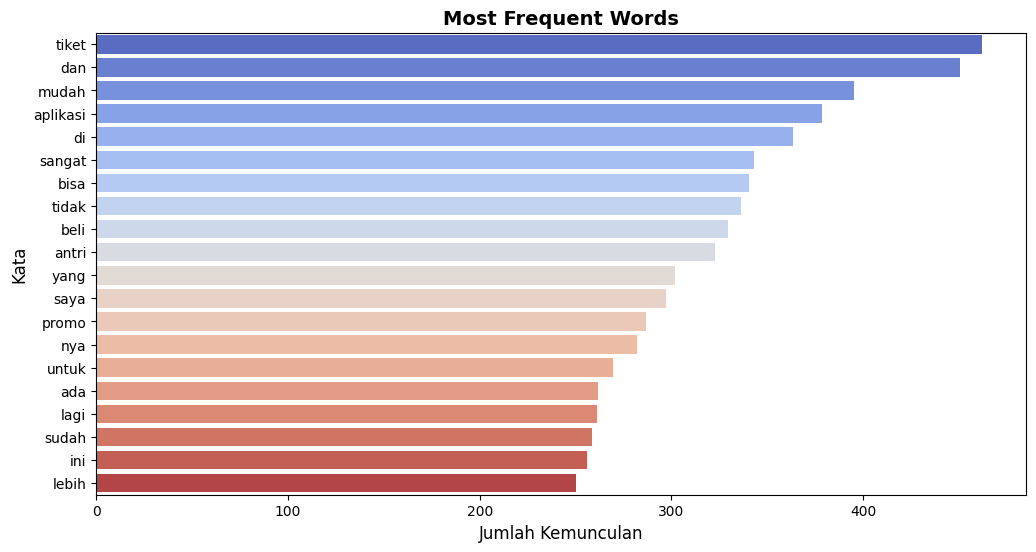

In [99]:
# Set ukuran figure
plt.figure(figsize=(12, 6))

# Visualisasi kata-kata paling sering muncul
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Hitung frekuensi setiap kata
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df.rename(columns={'index': 'kata'}, inplace=True)

# Sort berdasarkan jumlah kemunculan (frekuensi)
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

# Menambahkan kontras warna berdasarkan frekuensi (gradient)
colors = sns.color_palette("coolwarm", len(tfidf_df))

# Membuat barplot dengan kontras warna
sns.barplot(x='jumlah', y='kata', data=tfidf_df, palette=colors, hue='kata', dodge=False)

# Mengatur legenda agar tidak tampil jika tidak dibutuhkan
plt.legend([], [], frameon=False)

# Menambahkan judul dan label sumbu
plt.title('Most Frequent Words', fontsize=14, fontweight='bold')
plt.xlabel('Jumlah Kemunculan', fontsize=12)
plt.ylabel('Kata', fontsize=12)

# Tampilkan plot
plt.show()

### **Modelling**

### **Model 1: LSTM (70/30 Split)**

In [100]:
# Ekstrak teks dan labels dari cleaned dataframe
texts = clean_df['text_akhir'].tolist()
labels = clean_df['polarity'].tolist()

# Inisialisasi tokenizer dan urutkan
vocab_limit = 2500
text_tokenizer = Tokenizer(num_words=vocab_limit, split=' ')
text_tokenizer.fit_on_texts(texts)
sequences = text_tokenizer.texts_to_sequences(texts)
padded_inputs = pad_sequences(sequences)

# Encode labels ke format numerik
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

In [101]:
# Split data training dan test
X_train, X_test, y_train, y_test = train_test_split(padded_inputs, numeric_labels, test_size=0.3, random_state=42)

In [102]:
# Custom callback untuk menghentikan training jika akurasi validasi telah melebihi ambang batas/threshold
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.92:
            print(f"\nVal accuracy telah melampaui 0,92 pada epoch {epoch+1}. Pelatihan dihentikan.")
            self.model.stop_training = True

# Inisialisasi callback
early_stopping = CustomCallback()


In [103]:
# Membangun model LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_limit, output_dim=128, input_length=padded_inputs.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.4),
    tf.keras.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.4, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Optimasi: Learning rate scheduler
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-5
)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

# Training model dengan callback
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_schedule],
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 285ms/step - accuracy: 0.5859 - loss: 0.8783 - val_accuracy: 0.6768 - val_loss: 0.5992 - learning_rate: 5.0000e-04
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 295ms/step - accuracy: 0.6759 - loss: 0.6146 - val_accuracy: 0.7779 - val_loss: 0.4783 - learning_rate: 5.0000e-04
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 284ms/step - accuracy: 0.7900 - loss: 0.4542 - val_accuracy: 0.8386 - val_loss: 0.3649 - learning_rate: 5.0000e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.8494 - loss: 0.3509 - val_accuracy: 0.8612 - val_loss: 0.3251 - learning_rate: 5.0000e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 42s 290ms/step - accuracy: 0.8709 - loss: 0.3129 - val_accuracy: 0.8709 - val_loss: 0.2971 - learning_rate: 5.0000e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - accuracy: 0.8981 - loss: 0.2639 - val_accuracy: 0.8803 - val_loss: 0.2906 - learning_rate: 5.0000e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 286ms/step - 

In [104]:
# Evaluasi Model
print("\nEvaluasi Model LSTM:")

# Evaluasi pada data training
results_train_LSTM = model.evaluate(X_train, y_train, verbose=1)
print("Training Loss: %.2f" % results_train_LSTM[0])
print("Training Accuracy: %.2f" % results_train_LSTM[1])

# Evaluasi pada data testing (validation)
results_val_LSTM = model.evaluate(X_test, y_test, verbose=1)
print("Validation Loss: %.2f" % results_val_LSTM[0])
print("Validation Accuracy: %.2f" % results_val_LSTM[1])


Evaluasi Model LSTM:
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9507 - loss: 0.1358
Training Loss: 0.14
Training Accuracy: 0.95
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8918 - loss: 0.2793
Validation Loss: 0.29
Validation Accuracy: 0.89


In [105]:
# Menyimpah hasil lstm
model.save("model_lstm.h5")

### **Model 2: RNN (70/30 Split)**

In [106]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(padded_inputs, numeric_labels, test_size=0.3, random_state=42)

In [107]:
# Arsitektur Model RNN
model_rnn = Sequential()

# Embedding Layer
model_rnn.add(Embedding(input_dim=vocab_limit, output_dim=128, input_length=padded_inputs.shape[1]))

# Multiple RNN Layers
model_rnn.add(SimpleRNN(units=128, dropout=0.3, return_sequences=True))

# Simple RNN Layer
model_rnn.add(SimpleRNN(units=128, dropout=0.3, return_sequences=False))

# Fully Connected Layers
model_rnn.add(Dense(128, activation='relu'))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dropout(0.3))

# Output Layer
model_rnn.add(Dense(len(set(numeric_labels)), activation='softmax'))

# Compile Model
model_rnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Optimasi: Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-5)

# Latih Model
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=25,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - accuracy: 0.5659 - loss: 0.7011 - val_accuracy: 0.3562 - val_loss: 0.7278 - learning_rate: 0.0010
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.6083 - loss: 0.6663 - val_accuracy: 0.6851 - val_loss: 0.5768 - learning_rate: 0.0010
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.7337 - loss: 0.5243 - val_accuracy: 0.8326 - val_loss: 0.3833 - learning_rate: 0.0010
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 275ms/step - accuracy: 0.8702 - loss: 0.3214 - val_accuracy: 0.8072 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 275ms/step - accuracy: 0.8971 - loss: 0.2620 - val_accuracy: 0.8569 - val_loss: 0.3528 - learning_rate: 0.0010
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.9376 - loss: 0.1610 - val_accuracy: 0.7372 - val_loss: 0.5595 - learning_rate: 0.0010
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9356 - loss: 0.1

In [108]:
# Evaluasi Model
print("\nEvaluasi Model RNN:")

# Evaluasi pada data training
results_rnn_train = model_rnn.evaluate(X_train, y_train, verbose=1)
print(f"Training Loss: {results_rnn_train[0]:.2f}")
print(f"Training Accuracy: {results_rnn_train[1]:.2f}")

# Evaluasi pada data testing (validation)
results_rnn_val = model_rnn.evaluate(X_test, y_test, verbose=1)
print(f"Validation Loss: {results_rnn_val[0]:.2f}")
print(f"Validation Accuracy: {results_rnn_val[1]:.2f}")


Evaluasi Model RNN:
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9889 - loss: 0.0345
Training Loss: 0.04
Training Accuracy: 0.99
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8641 - loss: 0.4810
Validation Loss: 0.52
Validation Accuracy: 0.86


### **Model 3: CNN (80/20 Split)**

In [109]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(padded_inputs, numeric_labels, test_size=0.2, random_state=42)

In [110]:
# Arsitektur Model CNN
model_cnn = Sequential()

# Embedding Layer
model_cnn.add(Embedding(input_dim=vocab_limit, output_dim=128, input_length=padded_inputs.shape[1]))

# Multipel Conv1D Layer
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())

# Fully Connected Layer dengan Dropout
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.5))

# Output Layer untuk klasifikasi multi-kelas
model_cnn.add(Dense(len(set(numeric_labels)), activation='softmax'))

# Optimasi: learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-5
)

# Compile Model
model_cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Latih Model
history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=25,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.6469 - loss: 0.6084 - val_accuracy: 0.8059 - val_loss: 0.4571 - learning_rate: 0.0010
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.8465 - loss: 0.3658 - val_accuracy: 0.8494 - val_loss: 0.3357 - learning_rate: 0.0010
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.9100 - loss: 0.2366 - val_accuracy: 0.8574 - val_loss: 0.3328 - learning_rate: 0.0010
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.9380 - loss: 0.1705 - val_accuracy: 0.8579 - val_loss: 0.3859 - learning_rate: 0.0010
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.9541 - loss: 0.1247 - val_accuracy: 0.8439 - val_loss: 0.4603 - learning_rate: 0.0010
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9745 - loss: 0.0848
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.9744 - loss: 0.0849 

In [111]:
# Evaluasi Model
print("\nEvaluasi Model CNN:")

# Evaluasi pada data training
results_cnn_train = model_cnn.evaluate(X_train, y_train, verbose=1)
print(f"Training Loss: {results_cnn_train[0]:.2f}")
print(f"Training Accuracy: {results_cnn_train[1]:.2f}")

# Evaluasi pada data testing (validation)
results_cnn_val = model_cnn.evaluate(X_test, y_test, verbose=1)
print(f"Validation Loss: {results_cnn_val[0]:.2f}")
print(f"Validation Accuracy: {results_cnn_val[1]:.2f}")


Evaluasi Model CNN:
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9959 - loss: 0.0170
Training Loss: 0.02
Training Accuracy: 1.00
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8569 - loss: 0.5789
Validation Loss: 0.68
Validation Accuracy: 0.85


### **Model 4: GRU (80/20 Split)**

In [112]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(padded_inputs, numeric_labels, test_size=0.2, random_state=42)

In [113]:
# Arsitektur Model GRU
model_gru = Sequential()

# Embedding Layer
model_gru.add(Embedding(input_dim=vocab_limit, output_dim=256, input_length=padded_inputs.shape[1]))

# Multiple GRU Layers
model_gru.add(GRU(units=256, dropout=0.3, recurrent_dropout=0.3, return_sequences=False))

# Fully Connected Layers
model_gru.add(Dense(128, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.3))
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dropout(0.3))

# Output Layer Softmax
model_gru.add(Dense(len(set(numeric_labels)), activation='softmax'))

# Compile Model
model_gru.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Optimasi: Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-5
)

# Pelatihan Model
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6217 - loss: 0.6517 - val_accuracy: 0.6373 - val_loss: 0.6150 - learning_rate: 0.0010
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8254 - loss: 0.3901 - val_accuracy: 0.6793 - val_loss: 0.5392 - learning_rate: 0.0010
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8743 - loss: 0.3018 - val_accuracy: 0.7514 - val_loss: 0.4653 - learning_rate: 0.0010
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8892 - loss: 0.2588 - val_accuracy: 0.8264 - val_loss: 0.4192 - learning_rate: 0.0010
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9046 - loss: 0.2275 - val_accuracy: 0.8489 - val_loss: 0.3447 - learning_rate: 0.0010
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9262 - loss: 0.1955 - val_accuracy: 0.8634 - val_loss: 0.3165 - learning_rate: 0.0010
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9315 - loss: 0.1752 - val_accuracy: 

In [114]:
# Evaluasi Model
print("\nEvaluasi Model GRU:")

# Evaluasi pada data training
results_gru_train = model_gru.evaluate(X_train, y_train, verbose=1)
print(f"Training Loss: {results_gru_train[0]:.2f}")
print(f"Training Accuracy: {results_gru_train[1]:.2f}")

# Evaluasi pada data testing (validation)
results_gru_val = model_gru.evaluate(X_test, y_test, verbose=1)
print(f"Validation Loss: {results_gru_val[0]:.2f}")
print(f"Validation Accuracy: {results_gru_val[1]:.2f}")


Evaluasi Model GRU:
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.9760 - loss: 0.0691
Training Loss: 0.07
Training Accuracy: 0.98
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.8771 - loss: 0.3783
Validation Loss: 0.40
Validation Accuracy: 0.87


### **Evaluasi Model**

In [115]:
# Dictionary hasil evaluasi
models_results = {
    "LSTM": [results_train_LSTM[1], results_val_LSTM[1]],
    "RNN": [results_rnn_train[1], results_rnn_val[1]],
    "CNN": [results_cnn_train[1], results_cnn_val[1]],
    "GRU": [results_gru_train[1], results_gru_val[1]]
}

# Membuat DataFrame
df_accuracy = pd.DataFrame.from_dict(models_results, orient='index', columns=["Training Accuracy", "Validation Accuracy"])

# Menampilkan DataFrame
df_accuracy

,Training Accuracy,Validation Accuracy
LSTM,0.951537,0.886591
RNN,0.988563,0.859573
CNN,0.995747,0.849925
GRU,0.975231,0.873437


Berdasarkan hasil evaluasi model dalam kasus analisis sentimen, algoritma LSTM mencapai akurasi tertinggi sebesar 88,65%. Oleh karena itu, algoritma LSTM akan digunakan sebagai model utama untuk memprediksi sentimen pada kalimat baru.

### **Prediksi**

In [116]:
# Memuat model lstm
model = tf.keras.models.load_model('model_lstm.h5')

# Input teks baru
new_texts = ["sudah berhasil beli tiket, tapi pas masukin kode booking dan pass key di bioskop entah kenapa malah muncul keterangan kursi telah terbeli oleh orang lain, mana ga direfund lagi"]

# Tokenisasi dengan tokenizer yang sudah digunakan saat pelatihan
new_sequences = text_tokenizer.texts_to_sequences(new_texts)
new_padded_inputs = pad_sequences(new_sequences, maxlen=padded_inputs.shape[1])

# Prediksi menggunakan model yang telah dimuat
predictions_LSTM = model.predict(new_padded_inputs)

# Konversi ke kelas kategorikal
categorical_class = ["negatif", "positif", "netral"]
predicted_labels_LSTM = categorical_class[np.argmax(predictions_LSTM, axis=1)[0]]

# Menampilkan hasil prediksi
print(f"\nKalimat: {new_texts[0]}")
print(f"Sentimen: {predicted_labels_LSTM}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step

Kalimat: sudah berhasil beli tiket, tapi pas masukin kode booking dan pass key di bioskop entah kenapa malah muncul keterangan kursi telah terbeli oleh orang lain, mana ga direfund lagi
Sentimen: negatif


In [117]:
!pip freeze > requirements.txt